# Old Faithful Causal Inference
## Here we will implement methods for determining the direction of influence, i.e. $X \to Y$ vs $Y \to X$.

In [19]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
olf = pd.read_csv('legit_olf.csv', index_col=False)

In [3]:
len(olf)

272

In [4]:
olf.head(4)

,eruptions,waiting
0,3.600,79
1,1.800,54
2,3.333,74
3,2.283,62


### *RMK* That's not the best way to handle a dataframe. But let us proceed.

In [5]:
olf.waiting.describe()

count    272.000000
mean      70.897059
std       13.594974
min       43.000000
25%       58.000000
50%       76.000000
75%       82.000000
max       96.000000
Name: waiting, dtype: float64

In [6]:
olf.eruptions.describe()

count    272.000000
mean       3.487783
std        1.141371
min        1.600000
25%        2.162750
50%        4.000000
75%        4.454250
max        5.100000
Name: eruptions, dtype: float64

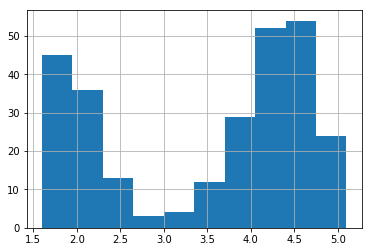

In [7]:
olf.eruptions.hist()

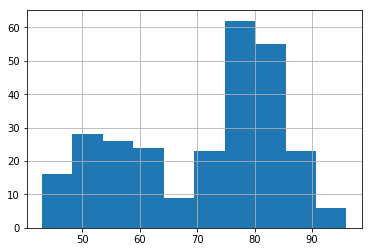

In [8]:
olf.waiting.hist()

### That's better. Now, let's enumerate the four cases. Henceforth, our model is $Y = f(X) + noise$. We will try each of the four following combinations of choices of $X$ and $Y$:
- **CASE I**: $X$ is eruption duration and $Y$ is the lag till the beginning of the next eruption (this is how the dataset comes to us).
- **CASE II**: $X$ is eruption duration and $Y$ is the length of time since the end of the previous eruption (the 'waiting' column is shifted forward).
- **CASE III**: $Y$ is eruption duration and $X$ is the lag till the beginning of the next eruption (this is the reverse of how the dataset comes to us - columns 'x' and 'y' are swapped).
- **CASE IV**: $Y$ is eruption duration and $X$ is the length of time since the end of the previous eruption (the 'waiting' column is shifted forward and then 'x' and 'y' are swapped).

### CASE I
$X$ is eruption duration and $Y$ is the lag till the beginning of the next eruption (this is how the dataset comes to us).

In [116]:
X, Y = olf.eruptions.copy(), olf.waiting.copy()
case1 = pd.concat([X,Y], axis = 1)
case1.columns = ['X','Y']

### Plotting

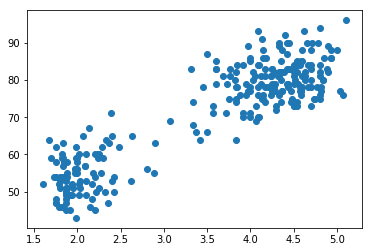

In [117]:
plt.scatter(case1.X, case1.Y)

### CASE II
$X$ is eruption duration and $Y$ is the length of time since the end of the previous eruption (the 'waiting' column is shifted forward).

In [149]:
X, Y = np.array(olf.eruptions.copy()[1:]), np.array(olf.waiting.copy()[:-1])
case2 = pd.DataFrame({'X':X,'Y':Y})

### Plotting

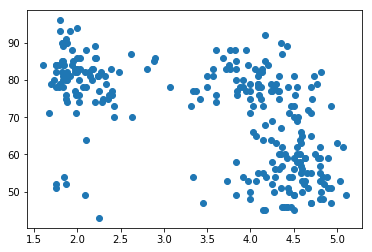

In [151]:
plt.scatter(X,Y)

### CASE III

In [153]:
Y, X = np.array(olf.eruptions.copy()), np.array(olf.waiting.copy())
case3 = pd.DataFrame({'X':X,'Y':Y})

### Plotting

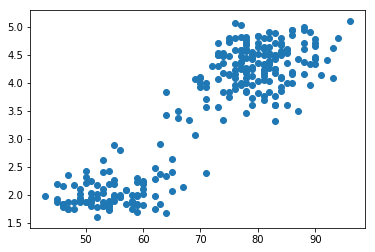

In [154]:
plt.scatter(X,Y)

### CASE IV

In [155]:
Y, X = np.array(olf.eruptions.copy()[1:]), np.array(olf.waiting.copy()[:-1])
case4 = pd.DataFrame({'X':X,'Y':Y})

### Plotting

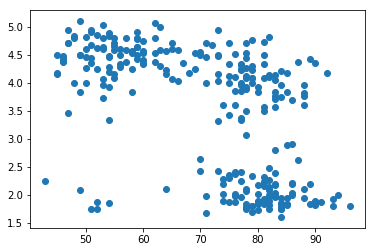

In [156]:
plt.scatter(X,Y)

### Great. Now it is time to do some regressions. We choose, for reasons to be made clear later, the family
$$ Y =  f(X) = aX + bX^3 + n $$

### Let us first take the simplest approach one can imagine: we map the given data to a $2D$ feature space via

$$ \Phi : X \mapsto (X,X^3)$$


In [69]:
import statsmodels.api as sm # For OLS regression

### CASE I, Regression

### First, we'll add in the additional feature.

In [370]:
case1['X3'] = case1.X.map(lambda x : x**3) # Adding nonlinear feature

# Now, we prepare to feed the data in
X_1 = np.vstack([case1.X.values,case1.X3.values]).transpose()

Y_1 = np.array(case1.Y.values)

### Now, we fit the model

In [158]:
results_1 = sm.OLS(Y_1,X_1).fit()

### And plot the original $X$ values (horizontal) against the residuals.

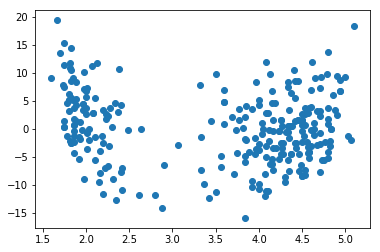

In [159]:
plt.scatter(case1.X,results_1.resid)

### The idea is that if $Y$ is a function of $X$, then we should expect less dependence between $X$ and the residuals. Visually, samples from the joint distribution of two independent random variables will be *rectangular*. Let's move on to the other cases, visually inspecting these residual plots.

### At the end, we'll implement a simple measure of dependence and compare its values in the various cases.

### CASE II, Regression

In [369]:
case2['X3'] = case2.X.map(lambda x : x**3) # Adding nonlinear feature

# Now, we prepare to feed the data in
X_2 = np.vstack([case2.X.values,case2.X3.values]).transpose()

Y_2 = np.array(case2.Y.values)

### Now, we fit the model

In [161]:
results_2 = sm.OLS(Y_2, X_2).fit()

### And plot the original $X$ values (horizontal) against the residuals.

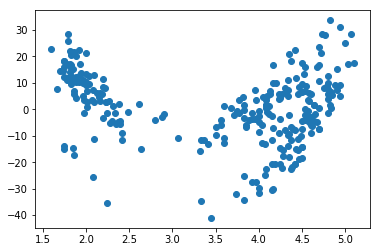

In [162]:
plt.scatter(case2.X,results_2.resid)

### Looking very much less rectangular than the first, I'd say.

### CASE III, Regression

In [366]:
case3['X3'] = case3.X.map(lambda x : x**3) # Adding nonlinear feature

# Now, we prepare to feed the data in
X_3 = np.vstack([case3.X.values,case3.X3.values]).transpose()

Y_3 = np.array(case3.Y.values)

### Now, we fit the model

In [367]:
results_3 = sm.OLS(Y_3, X_3).fit()

### And plot the original $X$ values (horizontal) against the residuals.

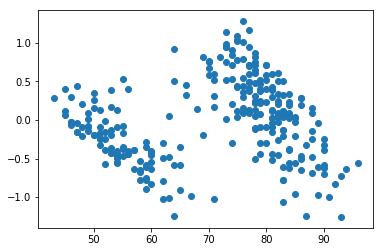

In [368]:
plt.scatter(case3.X,results_3.resid)

### Ditto.

### CASE IV, Regression

In [363]:
case4['X3'] = case4.X.map(lambda x : x**3) # Adding nonlinear feature

# Now, we prepare to feed the data in
X_4 = np.vstack([case4.X.values,case4.X3.values]).transpose()

Y_4 = np.array(case4.Y.values)

### Now, we fit the model

In [364]:
results_4 = sm.OLS(Y_4, X_4).fit()

### And plot the original $X$ values (horizontal) against the residuals.

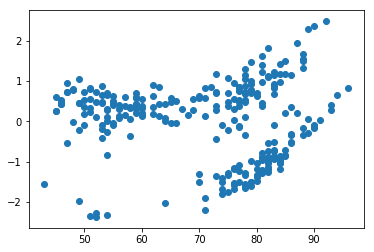

In [365]:
plt.scatter(case4.X,results_4.resid)

### Yeah, basically all of these look pretty goofy except for the first. Let's see if we can't quantify that.

### We are just about at the limit of reasonable copy-paste behavior. Therefore, let's define a function that will take the data frames `casen` as input.

In [239]:
from scipy import stats #To be used for density estimation

In [334]:
def depTest(frame):
    """
        Parameters:
            frame - a DataFrame
        
        Returns:
            The results of the
            Hoeffding Test
    """
    # Preparing Data
    X = np.array([frame.X.values,frame.X3.values]).transpose()
    Y = np.array(frame.Y.values
    resids = sm.OLS(Y, X).fit().resid
    joint = np.vstack([X[:,0],resids])
    
    # A model of the joint PDF
    kernel = stats.gaussian_kde(joint)
    kern = lambda x: kernel(x)[0]
    
    # Models of the marginals
    marginalX = stats.gaussian_kde(joint[0,:])
    margX = lambda x: marginalX(x)[0]
    marginalY = stats.gaussian_kde(joint[1,:])
    margY = lambda x: marginalY(x)[0]
    
    # Building a mesh
    Xs, Ys = np.mgrid[min(X[:,0]):max(X[:,0]):200j,min(resids):max(resids):200j]
    pos = np.vstack([Xs.ravel(),Ys.ravel()]).T
    
    # Estimating the integral
    grand = lambda x: ( (kern(x) - margX(x[0])*margY(x[1]))**2 ) * kern(x)
    
    
    return sum([grand(v) for v in pos])
    
    

### This didn't work. There are very many lazy assumptions in it, so we should not be surprised that it didn't work.

### How to proceed? Instead, let's use a basic histogram. The function `histDep` takes one of the `casen` frames and returns the lead singular value of the *difference between the joint frequency histogram and the tensor product of the marginal frequency histograms*.

In [403]:
def histDep(frame):
    """
        Parameters:
            frame - a DataFrame
        
        Returns:
            Lead singular value
            of the difference between 
            the joint frequency histogram 
            and the tensor product of the 
            marginal frequency histograms
    """
    
    # Preparing the data
    X = np.array([frame.X.values,frame.X3.values]).transpose()
    Y = np.array(frame.Y.values)
    
    # Computing residuals after fitting
    resids = sm.OLS(Y, X).fit().resid
    
    # Computing the 'densities'
    jHist = np.histogram2d(X[:,0],resids, bins=20, density=True)
    jX, jY = jHist[0].sum(axis=0), jHist[0].sum(axis=1)
    jX, jY = jX / jX.sum(), jY / jY.sum() # Normalizing
    
    # Preparing the matrices for linalg
    Joint = jHist[0][:,:]
    tensJoint = np.matmul(jX.reshape(-1,1),jY.reshape(1,20))
    jDiff = Joint - tensJoint
    
    return np.linalg.svd(jDiff)[1][0]


In [404]:
histDep(case1)

0.26578318816234503

In [405]:
histDep(case2)

0.11031973214660293

In [406]:
histDep(case3)

0.20449742460851725

In [407]:
histDep(case4)

0.08766266861990527

### Even worse.